# Analyze the results given by NAS

## Build the network given by NAS 

In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')


import iterative_naive_nas

from sklearn.model_selection import train_test_split

import tensorflow.compat.v1 as tf

import numpy as np

import custom_training

import utils.losses_utils as losses

import utils.data_utils as data_utils

import viz_results as viz

import matplotlib.pyplot as plt

#30_paritions
#optimized_parameters = [3.46661820e-04, 4.01120020e-01, 9.09580986e-01, 4.13090818e-01,
# 3.93104672e-01, 8.00000000e+00, 8.20000000e+02]
#25_partitions
optimized_parameters = [6.80863834e-04, 4.68269339e-01, 4.51964628e-01, 1.80029101e-01,
 3.94141219e-01, 2.00000000e+00, 7.20000000e+02]
#21_partitions
#optimized_parameters = [1.0e-14, 1.0e-04, 1.0e+00, 1.0e-04, 0.0e+00, 1.6e+01, 8.2e+02]

learning_rate = float(optimized_parameters[0])
l1_penalization_eeg = float(optimized_parameters[1])
l1_penalization_bold = float(optimized_parameters[2])
l1_penalization_decoder = float(optimized_parameters[3])
loss_coefficient = float(optimized_parameters[4])
batch_size = int(optimized_parameters[5])
current_shape = int(optimized_parameters[6])
#eeg_hidden_shape = int(optimized_parameters[6])
#bold_hidden_shape = int(optimized_parameters[7])
#decoder_hidden_shape = int(optimized_parameters[8])

bold_shift=3
f_resample=1.8
n_partitions=25

eeg_file='../../optimized_nets/eeg/eeg_' + str(n_partitions) + '_partitions.json'
bold_file='../../optimized_nets/bold/bold_' + str(n_partitions) + '_partitions.json'
decoder_file='../../optimized_nets/decoder/decoder_' + str(n_partitions) + '_partitions.json'

/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/davidcalhas/anaconda3/envs/fmri_eeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/davidcalhas/anacond

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(40, 2607, 8)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(80, 2607, 8)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(120, 2607, 8)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(160, 2607, 8)
Extracting parameters from /home/davidcalhas/ee

In [2]:
eeg_train, bold_train, eeg_val, bold_val = data_utils.load_data(list(range(10)), 
                                                                list(range(10, 12)), 
                                                                bold_shift=bold_shift, 
                                                                n_partitions=n_partitions, f_resample=f_resample,
                                                                roi=1, roi_ica_components=20)

#standardize data
eeg_train, bold_train, eeg_scaler, bold_scaler = data_utils.standardize(eeg_train, bold_train)
eeg_val, bold_val, _, _ = data_utils.standardize(eeg_val, bold_val, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

n_voxels = bold_train.shape[1]

print("Finished Loading Data")

X_train_eeg, X_train_bold, tr_y = data_utils.create_eeg_bold_pairs(eeg_train, bold_train)
X_val_eeg, X_val_bold, tv_y = data_utils.create_eeg_bold_pairs(eeg_val, bold_val)


X_train_eeg = X_train_eeg.astype(np.float32)
X_train_bold = X_train_bold.astype(np.float32)
X_val_eeg = X_val_eeg.astype(np.float32)
X_val_bold = X_val_bold.astype(np.float32)


tr_y = np.array(tr_y, dtype=np.float32)
tv_y = np.array(tv_y, dtype=np.float32)

eeg_train = eeg_train.astype('float32')
bold_train = bold_train.astype('float32')
eeg_val = eeg_val.astype('float32')
bold_val = bold_val.astype('float32')

print("Pairs Created")

_, _, eeg_test, bold_test = data_utils.load_data(list(range(0)), list(range(12, 16)), 
                                                 bold_shift=bold_shift, 
                                                 n_partitions=n_partitions, 
                                                 f_resample=f_resample, 
                                                 roi=1, roi_ica_components=20)

eeg_test, bold_test, _, _ = data_utils.standardize(eeg_test, bold_test, eeg_scaler=eeg_scaler, bold_scaler=bold_scaler)

eeg_test = eeg_test.astype('float32')
bold_test = bold_test.astype('float32')

Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr...
Setting channel info structure...
Reading 0 ... 162022  =      0.000 ...   648.088 secs...
(25, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 197234  =      0.000 ...   788.936 secs...
(50, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 181949  =      0.000 ...   727.796 secs...
(75, 2607, 14)
Extracting parameters from /home/davidcalhas/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr...
Setting channel info structure...
Reading 0 ... 195159  =      0.000 ...   780.636 secs...
(100, 2607, 14)
Extracting parameters from /home/davidcalhas

### Train the network

In [3]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

eeg_input_shape = (eeg_train.shape[1], eeg_train.shape[2], eeg_train.shape[3], eeg_train.shape[4])
bold_input_shape=(bold_train.shape[1], bold_train.shape[2], bold_train.shape[3])

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=40, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

model_name = "LComb"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Encoder Loss:  0.16452207  || Decoder Loss:  -0.034627363 Validation Decoder Loss:  -0.30855432
Encoder Loss:  0.1514482  || Decoder Loss:  -0.07345838 Validation Decoder Loss:  -0.13592221
Encoder Loss:  0.16907653  || Decoder Loss:  -0.17626685 Validation Decoder Loss:  -0.012904229
Encoder Loss:  0.17058948  || Decoder Loss:  -0.2544649 Validation Decoder Loss:  -0.046072826
Encoder Loss:  0.18736455  || Decoder Loss:  -0.28753883 Validation Decoder Loss:  -0.05805346
Encoder Loss:  0.20195526  || Decoder Loss:  -0.31162634 Validation Decoder Loss:  -0.06450255
Encoder Loss:  0.2130975  || Decoder Loss:  -0.3299849 Validation Decoder Loss:  -0.0780893
Encoder Loss:  0.22234347  || Decoder Loss:  -0.34528542 Validation Decoder Loss:  -0.08593641
Encoder Loss:  0.23054665  || Decoder Loss:  -0.35820204 Validation Decoder Loss:  -0.091044605
Encoder Loss:  0.23779331  || Decoder Loss:  -0.3707

train set mean:  -0.1798075155634433
train set std:  0.2651343376152711
validation set mean:  -0.2724777489900589
validation set std:  0.001842496714712165
test set mean:  -0.2708409813046455
test set std:  0.0023954733024958152


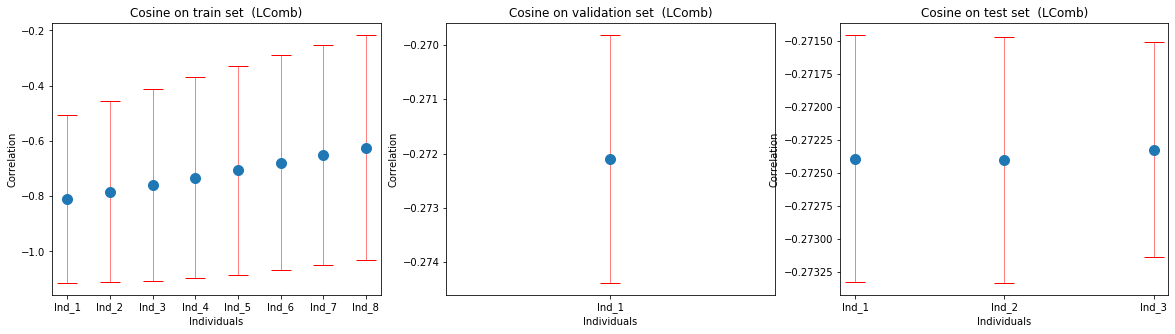

train set mean:  375.65385485839846
train set std:  43.39086203397434
validation set mean:  1950.9080810546875
validation set std:  2.755715854187003
test set mean:  1948.2379138183594
test set std:  5.818426995282904


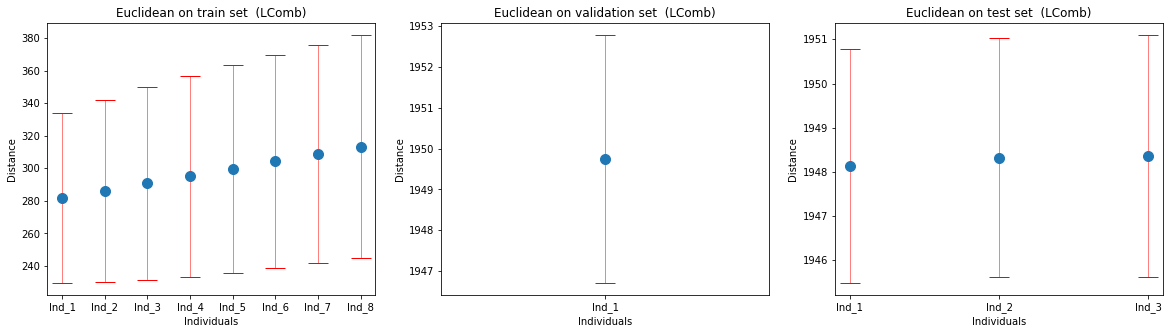

In [4]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

### Try the same hyperparameters, but in an autoencoder training process without the bold branch

In [5]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

auto_encoder_model = custom_training.auto_encoder_network(eeg_input_shape, eeg_network, decoder_network)

validation_loss = custom_training.autoencoder_training(X_train_eeg, 
                     X_train_bold, 
                     auto_encoder_model, 
                     epochs=40, 
                     auto_encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                     batch_size=batch_size, 
                     X_val_eeg=eeg_val, 
                     X_val_bold=bold_val)

model_name = "AE"

Autoencoder Loss:  -0.08313323 || Validation Autoencoder Loss:  -0.17064169
Autoencoder Loss:  -0.33233786 || Validation Autoencoder Loss:  -0.047072176
Autoencoder Loss:  -0.4950342 || Validation Autoencoder Loss:  -0.08585052
Autoencoder Loss:  -0.52233523 || Validation Autoencoder Loss:  -0.07499464
Autoencoder Loss:  -0.53492004 || Validation Autoencoder Loss:  -0.06501386
Autoencoder Loss:  -0.54312754 || Validation Autoencoder Loss:  -0.061480895
Autoencoder Loss:  -0.5495116 || Validation Autoencoder Loss:  -0.059398
Autoencoder Loss:  -0.5556077 || Validation Autoencoder Loss:  -0.059029806
Autoencoder Loss:  -0.56169343 || Validation Autoencoder Loss:  -0.04723952
Autoencoder Loss:  -0.5691701 || Validation Autoencoder Loss:  -0.08188831
Autoencoder Loss:  -0.57950175 || Validation Autoencoder Loss:  -0.13293941
Autoencoder Loss:  -0.5911561 || Validation Autoencoder Loss:  -0.038699966
Autoencoder Loss:  -0.60837096 || Validation Autoencoder Loss:  -0.038272265
Autoencoder Lo

train set mean:  -0.1524548718216829
train set std:  0.24552168027799648
validation set mean:  -0.010899870142166037
validation set std:  0.007419759003592717
test set mean:  -0.014580789046740393
test set std:  0.00664652061160925


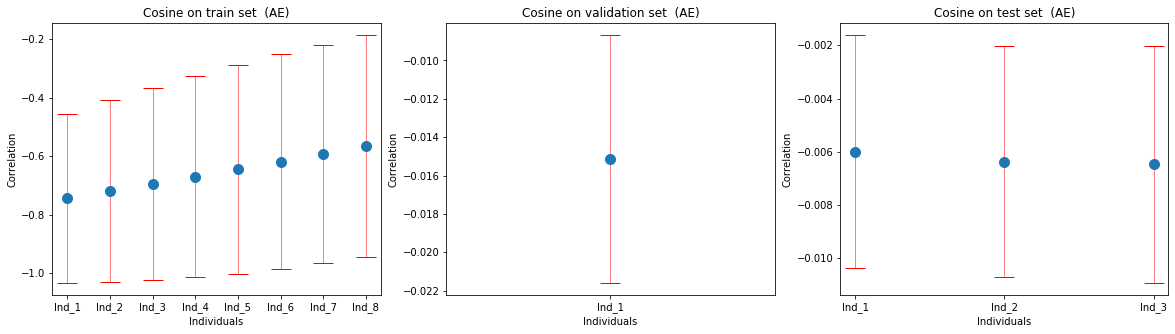

train set mean:  528.104827758789
train set std:  56.729358759687315
validation set mean:  1920.7203051757813
validation set std:  37.18564211536663
test set mean:  1966.1116943359375
test set std:  195.44409511941438


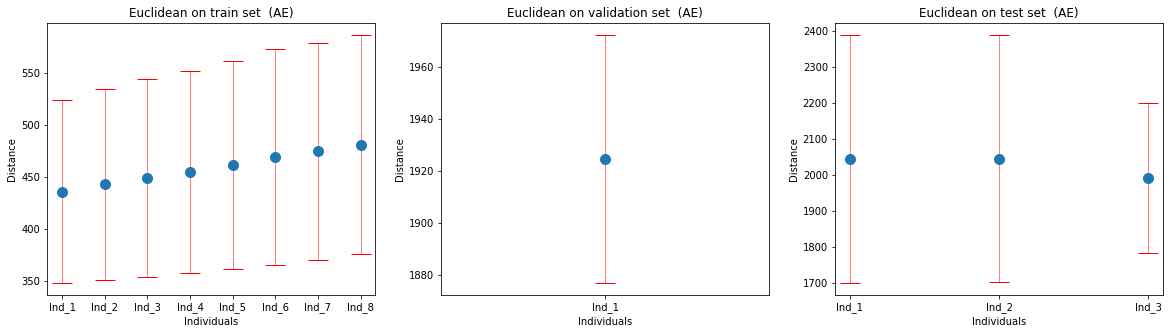

In [6]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

### Try the same hyperparameters, but in an adversarial training process

In [7]:
eeg_network, bold_network, decoder_network = viz.get_models_and_shapes(eeg_file=eeg_file, 
                                                                      bold_file=bold_file, 
                                                                      decoder_file=decoder_file)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=40, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

model_name = "GAN"

GAN Encoder Loss:  1.6428517  || GAN Decoder Loss:  0.30143645  || GAN Validation Decoder Loss:  -0.63411397  || Train Reconstruction Loss:  -0.03706288  || Validation Reconstruction Loss:  -0.63411397
GAN Encoder Loss:  2.4882896  || GAN Decoder Loss:  0.39746484  || GAN Validation Decoder Loss:  -0.13880941  || Train Reconstruction Loss:  -0.045423105  || Validation Reconstruction Loss:  -0.13880943
GAN Encoder Loss:  3.2975745  || GAN Decoder Loss:  0.010559646  || GAN Validation Decoder Loss:  -0.12258816  || Train Reconstruction Loss:  -0.03558626  || Validation Reconstruction Loss:  -0.12258816
GAN Encoder Loss:  3.4558408  || GAN Decoder Loss:  0.007130316  || GAN Validation Decoder Loss:  -0.12503475  || Train Reconstruction Loss:  -0.05141354  || Validation Reconstruction Loss:  -0.12503475
GAN Encoder Loss:  3.4624887  || GAN Decoder Loss:  0.0072864834  || GAN Validation Decoder Loss:  -0.11989204  || Train Reconstruction Loss:  -0.049135607  || Validation Reconstruction Los

KeyboardInterrupt: 

train set mean:  nan
train set std:  nan
validation set mean:  nan
validation set std:  nan
test set mean:  nan
test set std:  nan


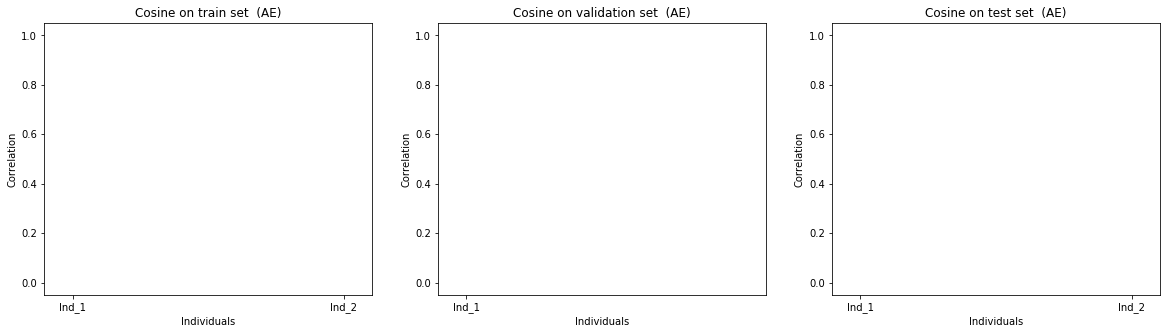

train set mean:  inf
train set std:  nan
validation set mean:  inf
validation set std:  nan
test set mean:  inf
test set std:  nan


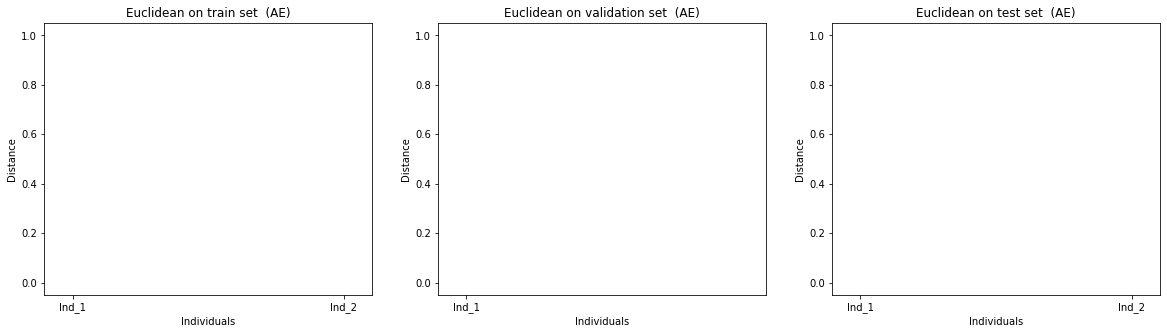

In [8]:
viz.plot_loss_results(eeg_train, bold_train, eeg_val, bold_val, eeg_test, bold_test, eeg_network, decoder_network, model_name)

### Try to check if alternate training between LComb and GAN training

In [ ]:
#eeg_network, bold_network, decoder_network = get_models_and_shapes()

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False)


validation_loss = custom_training.linear_combination_training(X_train_eeg, 
                                                            X_train_bold, 
                                                            tr_y, 
                                                            eeg_network, 
                                                            decoder_network, 
                                                            multi_modal_model, 
                                                            epochs=5, 
                                                            encoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            decoder_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                                            batch_size=batch_size, 
                                                            linear_combination=loss_coefficient,
                                                            X_val_eeg=X_val_eeg,
                                                            X_val_bold=X_val_bold,
                                                            tv_y=tv_y)

multi_modal_model = custom_training.multi_modal_network(eeg_input_shape, bold_input_shape, eeg_network, bold_network, dcca=False, corr_distance=True)

validation_loss = custom_training.adversarial_training(X_train_eeg, 
                                                       X_train_bold, 
                                                       tr_y, 
                                                       eeg_network, decoder_network, multi_modal_model, 
                                                       epochs=5, 
                                                       discriminator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       generator_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                                                       batch_size=batch_size, 
                                                       linear_combination=loss_coefficient, 
                                                       X_val_eeg=X_val_eeg, 
                                                       X_val_bold=X_val_bold, 
                                                       tv_y=tv_y)

In [ ]:
def euclidean_volume(x, y):
    n_volumes_distance = tf.keras.backend.sqrt(tf.keras.backend.sum(tf.keras.backend.square(x - y), axis=1))
    n_volumes_distance = tf.keras.backend.sum(n_volumes_distance, axis=1)
    return tf.keras.backend.mean(n_volumes_distance)
    

euclidean_volume(bold_train[0:15], bold_test[0:15])